# Defining spatially-varying dielectric structures 

When a regular `Tidy3D` [Medium](../api/_autosummary/tidy3d.Medium.html) or a dispersive medium such as [Lorentz](../api/_autosummary/tidy3d.Lorentz.html) is assigned to a [Structure](../api/_autosummary/tidy3d.Structure.html), the refractive index is homogeneous within the geometry. In some cases, such as gradient-index optics component and inhomogeneous doped structure simulations, a spatially varying refractive index distribution is desirable. In principle, this can be achieved by manually dividing the [Structure](../api/_autosummary/tidy3d.Structure.html) into smaller sub-components and assigning a refractive index value to each component according to the spatial distribution. However, this process can be tedious and error-prone. Fortunately, `Tidy3D` supports both **non-dispersive** and **dispersive** media that have a spatially varying refractive index, and thus can help you achieve this result very conveniently.

In this tutorial, first we illustrate how to define structures made of custom **non-dispersive** medium called [CustomMedium](../api/_autosummary/tidy3d.CustomMedium.html) that allow for a customized refractive index spatial profile. An example is an ideal gradient index lens that has flat surfaces but a parabolic distribution of refractive index. The simulation result allows us to examine the focusing capability of the lens. 

Next, we illustrate how to define structures made of custom **dispersive** medium. As an example, we construct a lens made of [CustomLorentz](../api/_autosummary/tidy3d.CustomLorentz.html) that has the ideal refractive index distribution at the frequency of interest.

Finally, we explain how to construct a **diagonally anisotropic** medium in which each component can be independently defined as any type of custom dispersive or non-dispersive medium.

<img src="img/graded_index_lens.png" width="300" alt="Schematic of the graded index lens">

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import tidy3d as td
from tidy3d import web
from tidy3d import SpatialDataArray


The lens is designed to work at 1 $\mu m$ wavelength.

In [2]:
lda0 = 1  # central wavelength

freq0 = td.C_0 / lda0  # central frequency


## Custom Non-dispersive Medium

With [CustomMedium](../api/_autosummary/tidy3d.CustomMedium.html), one can customize the spatial profile of non-dispersive refractive index inside a structure. The spatial profile is defined with [SpatialDataAarray](../api/_autosummary/tidy3d.SpatialDataArray.html) where we provide scalar data such as refractive index and labeled coordinates. Below, let's see how to define a flat lens whose index of refraction follows $n(r)=n_0(1-Ar^2)$, where $r$ is the radial distance to the $z$-axis. In this particular example, we study a lens of 20 $\mu m$ radius and 10 $\mu m$ thickness.

First, we define the spatial grids. The refractive index is invariant alone $z$-axis, and varies in the $x$-$y$ plane. For the uniform $z$-axis, we only need to supply one grid point since [CustomMedium](../api/_autosummary/tidy3d.CustomMedium.html) will automatically generate uniform profiles along the axis where a single grid point is supplied. In the $x$ and $y$ dimensions, we set 100 grid points to fully resolve the refractive index variation.

In [3]:
Nx, Ny, Nz = 100, 100, 1 # number of grid points along each dimension

r = 20  # radius of the lens, unit: micron
t = 10  # thickness of the lens, unit: micron

# The coordinate for the refractive index data that includes x, y, z, and frequency
# Note: when only one coordinate is supplied along an axis, it means the medium is uniform along this axis.
X = np.linspace(-r, r, Nx)  # x grid
Y = np.linspace(-r, r, Ny)  # y grid
Z = [0]  # z grid


Next, we define a 3-dimensional array that stores the refractive index.

In [4]:
# define coordinate array
x_mesh, y_mesh, z_mesh = np.meshgrid(X, Y, Z, indexing="ij")
r_mesh = np.sqrt(x_mesh**2 + y_mesh**2)  # radial distance

# index of refraction array
# assign the refractive index value to the array according to the desired profile
n_data = np.ones((Nx, Ny, Nz))
n0 = 2
A = 1e-3
n_data[r_mesh <= r] = n0 * (1 - A * r_mesh[r_mesh <= r] ** 2)


Finally, we convert the numpy array to a [SpatialDataArray](../api/_autosummary/tidy3d.SpatialDataArray.html) that labels the coordinate.

In [5]:
# convert to dataset array
n_dataset = SpatialDataArray(n_data, coords=dict(x=X, y=Y, z=Z))


### Defining CustomMedium in 3 Ways
Here, we will illustrate defining custom medium in three different ways:
1. Using classmethod [td.CustomMedium.from_nk](../api/_autosummary/tidy3d.CustomMedium.html#tidy3d.CustomMedium.from_nk) when refractive index and extinction coefficients are readily available.
2. Using classmethod [td.CustomMedium.from_eps_raw](../api/_autosummary/tidy3d.CustomMedium.html#tidy3d.CustomMedium.from_eps_raw) to supply permittivity data, which can be complex-valued for lossy medium.
3. Define permittivity and conductivity directly in `td.CustomMedium`.

(One can also define permittivity for each component separately via [PermittivityDataset](../api/_autosummary/tidy3d.PermittivityDataset.html), but it is to be deprecated in the future. For custom medium that is anisotropic, it is encouraged to define through [CustomAnisotropicMedium](../api/_autosummary/tidy3d.CustomAnisotropicMedium.html))

In any of the three ways, you can optionally define how the permittivity is **interpolated** to Yee-grid with `interp_method` that can take the value of "linear" or "nearest". The default value is "nearest". If the custom medium is applied to a geometry larger than the custom medium's grid range, **extrapolation** is automatically applied for Yee grids outside the supplied coordinate region. When the extrapolated value is smaller (greater) than the minimal (maximal) of the supplied data, the extrapolated value will take the minimal (maximal) of the supplied data.

In [6]:
## Three equivalent ways of defining custom medium for the lens

# define custom medium with n/k data
mat_custom1 = td.CustomMedium.from_nk(n_dataset, interp_method="nearest")

# define custom medium with permittivity data
eps_dataset = n_dataset**2
mat_custom2 = td.CustomMedium.from_eps_raw(eps_dataset, interp_method="nearest")

# define permittivity directly in the class
mat_custom3 = td.CustomMedium(permittivity=eps_dataset, interp_method="nearest")


Note that when the medium is **lossy** so that `k` is non-zero and permittivity is complex-valued, in Approach 3, one can directly define the conductivity in the class:

```
mat_custom3 = td.CustomMedium(permittivity=eps_dataset, conductivity=conductivity_dataset, interp_method="nearest")
```

In the other two approaches, the frequency value at each the complex-valued permittivity or ``n``/``k`` is defined is needed to evaluate the conductivity. There are two ways to supply the frequency information:

- Pass through `freq` kwarg in the classmethod [td.CustomMedium.from_nk](../api/_autosummary/tidy3d.CustomMedium.html#tidy3d.CustomMedium.from_nk) and [td.CustomMedium.from_eps_raw](../api/_autosummary/tidy3d.CustomMedium.html#tidy3d.CustomMedium.from_eps_raw)
- Supply ``n``/``k`` or permittivity through [ScalarFieldDataArray](../api/_autosummary/tidy3d.SpatialDataArray.html) that contains a frequency coordinate.

### Simulation Setup
#### Define Lens Structure 

In [7]:
# define the lens structure as a box
lens = td.Structure(
    geometry=td.Box(center=(0, 0, t / 2), size=(td.inf, td.inf, t)), medium=mat_custom1
)


#### Define a Source and Monitor

In [8]:
# define a plane wave source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 20),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -lda0),
    direction="+",
    pol_angle=0,
)


# define a field monitor in the xz plane at y=0
monitor_field_xz = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, td.inf], freqs=[freq0], name="field_xz"
)


#### Define a Simulation 

In [9]:
# simulation domain size
Lx, Ly, Lz = 2 * r, 2 * r, 5 * t
sim_size = (Lx, Ly, Lz)

run_time = 2e-12  # simulation run time

# define simulation
sim = td.Simulation(
    center=(0, 0, Lz / 2 - lda0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=10, wavelength=lda0),
    structures=[lens],
    sources=[plane_wave],
    monitors=[monitor_field_xz],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(
        boundary=td.PML()
    ),  # pml is applied in all boundaries
    symmetry=(
        -1,
        1,
        0,
    ),  # symmetry is used such that only a quarter of the structure needs to be modeled.
)


### Visualize the Simulation and Gradient Index Distribution 

We can use the `plot_eps` method of [Simulation](../api/_autosummary/tidy3d.Simulation.html) to visualize the simulation setup as well as the permittivity distribution. 

First, plot the $yz$ plane at $x$=0.

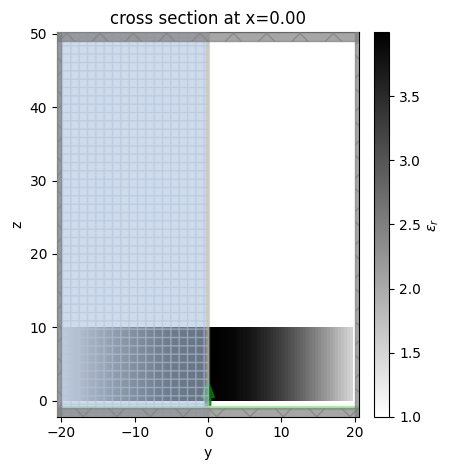

In [10]:
sim.plot_eps(x=0)
plt.show()


Similarly, plot the $xy$ plane at $z$=0. The spatially varying permittivity is clearly observed.

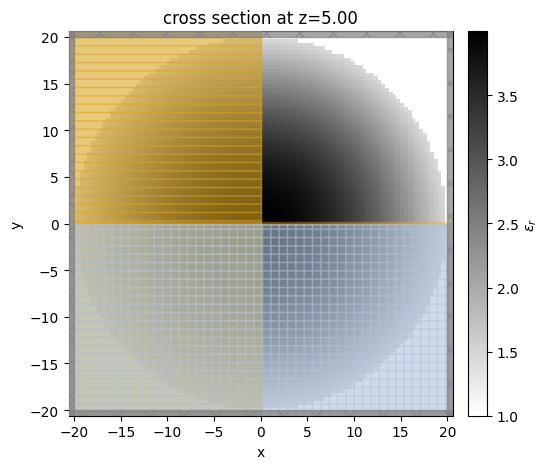

In [11]:
sim.plot_eps(z=t / 2)
plt.show()


### Submit Simulation Job 

Submit the simulation job to the server.

In [12]:
sim_data = web.run(
    sim,
    task_name="gradient_index_lens",
    path="data/simulation.hdf5",
    verbose=True,
)


20:53:11 PST Created task 'gradient_index_lens' with task_id                    
             'fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=911751;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=369935;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\taskId]8;;\]8;id=911751;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\=]8;;\]8;id=248523;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\fdve]8;;\]8;id=911751;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\-dfca3819-e37]8;;\
             ]8;id=911751;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\f-4cfe-9a48-24aaaafbd242']8;;\.

Output()

20:53:13 PST status = queued

Output()

20:53:16 PST status = preprocess

20:53:19 PST Maximum FlexCredit cost: 0.675. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

20:53:20 PST running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

20:54:26 PST early shutoff detected at 80%, exiting.

20:54:27 PST status = postprocess

Output()

20:54:28 PST status = success

20:54:29 PST View simulation result at                                          
             ]8;id=934714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=389421;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\taskId]8;;\]8;id=934714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\=]8;;\]8;id=859424;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\fdve]8;;\]8;id=934714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\-dfca3819-e37]8;;\
             ]8;id=934714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dfca3819-e37f-4cfe-9a48-24aaaafbd242\f-4cfe-9a48-24aaaafbd242']8;;\.

Output()

20:54:30 PST loading simulation from data/simulation.hdf5

### Result Visualization 

After the simulation is complete, we can inspect the focusing capability of the gradient-index lens by plotting the field distributions. First, plot $E_x$ in the $xz$ plane at $y=0$.

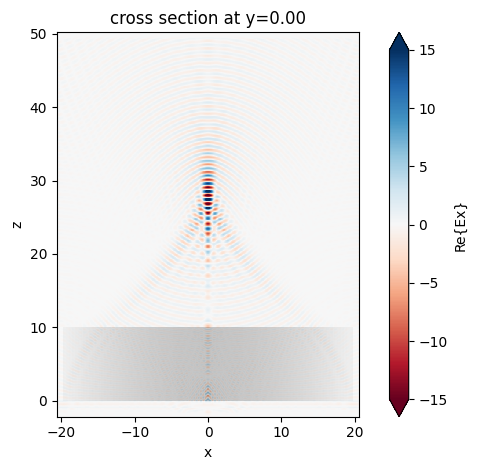

In [13]:
sim_data.plot_field("field_xz", "Ex", vmin=-15, vmax=15)
plt.show()


The focus is better visualized by plotting the field intensity. A strong focus about 17 $\mu m$ from the front surface of the lens is observed.

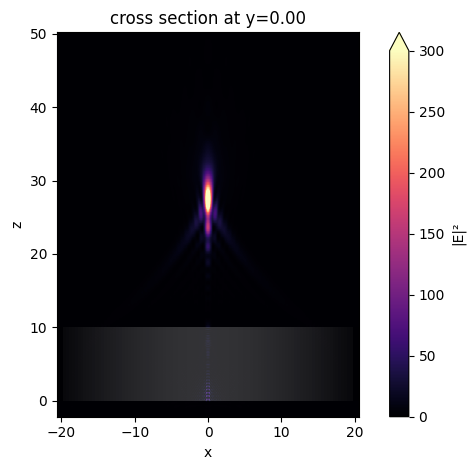

In [14]:
sim_data.plot_field("field_xz", "E", "abs^2", vmin=0, vmax=300)
plt.show()


## Custom Dispersive Medium

Tidy3d supports a set of dispersive media: [PoleResidue](../api/_autosummary/tidy3d.PoleResidue.html), [Lorentz](../api/_autosummary/tidy3d.Lorentz.html), [Sellmeier](../api/_autosummary/tidy3d.Sellmeier.html), [Drude](../api/_autosummary/tidy3d.Drude.html), and [Debye](../api/_autosummary/tidy3d.Debye.html). Each of them has been generalized to support spatially varying profile. The class for spatially varying medium has a prefix "Custom". For example, we can define a spatially varying Lorentz model with [CustomLorentz](../api/_autosummary/tidy3d.CustomLorentz.html) class.

The usage of the "Custom" dispersive medium class is very similar to that of the regular medium. When defining a custom dispersive medium object, we simply replace the input fields that are scalar in the regular medium with [SpatialDataAarray](../api/_autosummary/tidy3d.SpatialDataArray.html), which defines the spatial profile with labeled coordinates. Take Lorentz model as an example, there are two input fields: a scalar `eps_inf` that defines the relative permittivity at infinite frequency, and a nested tuple of scalar `coeffs` that defines the oscillator properties including oscillator strength, frequency, and damping rate. In [CustomLorentz](../api/_autosummary/tidy3d.CustomLorentz.html), the scalar `eps_inf` turns into [SpatialDataAarray](../api/_autosummary/tidy3d.SpatialDataArray.html), and the nested tuple of scalar `coeffs` turns into a nested tuple of [SpatialDataAarray](../api/_autosummary/tidy3d.SpatialDataArray.html). An example is illustrated below:


In [15]:
# spatially varying Lorentz model that has the same permittivity profile as
# the custom non-dispersive medium at `freq0`.
eps_inf_dataset = xr.ones_like(eps_dataset) # uniform eps_inf
f0_dataset = xr.ones_like(eps_inf_dataset)*2*freq0 # uniform oscillator frequency as well
gamma_dataset = xr.zeros_like(eps_inf_dataset) # lossless oscillator
delep_dataset = (eps_dataset-1)*3/4 # non-uniform oscillator strength
mat_lorentz = td.CustomLorentz(eps_inf=eps_inf_dataset, coeffs=((delep_dataset, f0_dataset, gamma_dataset),))


Note that all input fields must be defined over the same spatial grids. In this example, the data of `eps_inf` and all terms in `coeffs` are defined over the same spatial grids.

### Setup  Simulation with Spatially Varying Lorentz Medium

In [16]:
lens_lorentz = lens.copy(update={"medium":mat_lorentz})
sim_lorentz = sim.copy(update={"structures":[lens_lorentz]})

### Visualize the Simulation and Gradient Index Distribution

Let's visualize the simulation on the same plane as before. To view the permittivity distribution at `freq0`, we set the kwarg `freq=freq0`. The permittivity distribution at `freq0` looks the same as the previous custom non-dispersive medium example.

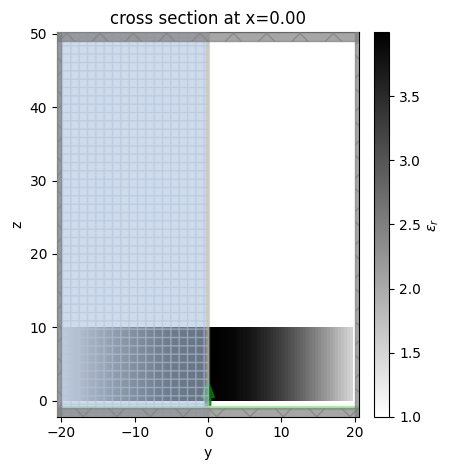

In [17]:
sim_lorentz.plot_eps(x=0, freq=freq0)
plt.show()


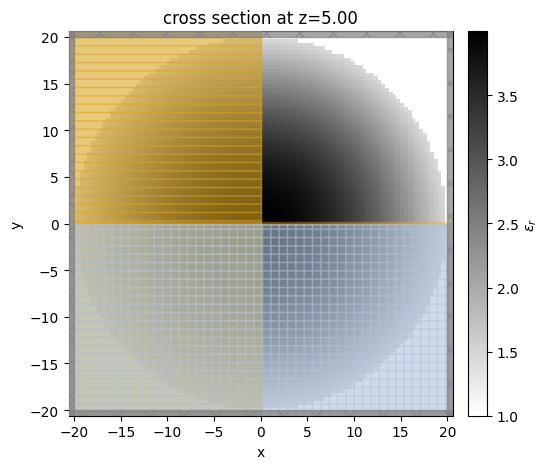

In [18]:
sim_lorentz.plot_eps(z=t / 2, freq=freq0)
plt.show()


### Submit Simulation Job

Submit the simulation job to the server.

In [19]:
sim_data_lorentz = web.run(
    sim_lorentz,
    task_name="gradient_index_lens_lorentz",
    path="data/simulation_lorentz.hdf5",
    verbose=True,
)


20:54:35 PST Created task 'gradient_index_lens_lorentz' with task_id            
             'fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=711342;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=347456;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\taskId]8;;\]8;id=711342;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\=]8;;\]8;id=330845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\fdve]8;;\]8;id=711342;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\-e1fc7e39-7ff]8;;\
             ]8;id=711342;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\c-4831-9e10-2f9b4dde9064']8;;\.

Output()

20:54:36 PST status = queued

Output()

20:54:40 PST status = preprocess

20:54:45 PST Maximum FlexCredit cost: 0.878. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

20:56:34 PST early shutoff detected at 96%, exiting.

             status = postprocess

Output()

20:56:36 PST status = success

             View simulation result at                                          
             ]8;id=142355;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=8565;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\taskId]8;;\]8;id=142355;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\=]8;;\]8;id=206952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\fdve]8;;\]8;id=142355;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\-e1fc7e39-7ff]8;;\
             ]8;id=142355;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e1fc7e39-7ffc-4831-9e10-2f9b4dde9064\c-4831-9e10-2f9b4dde9064']8;;\.

Output()

20:56:37 PST loading simulation from data/simulation_lorentz.hdf5

### Result Visualization

After the simulation is complete, we inspect the focusing capability of the gradient-index lens by plotting the field distributions on the same plane as before. Again, at `freq0`, the result is consistent with the previous simulation.

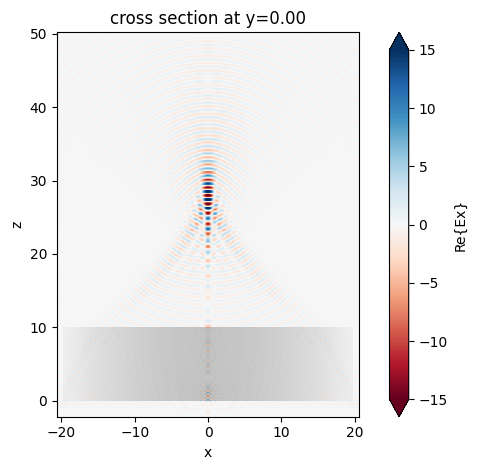

In [20]:
sim_data_lorentz.plot_field("field_xz", "Ex", vmin=-15, vmax=15)
plt.show()


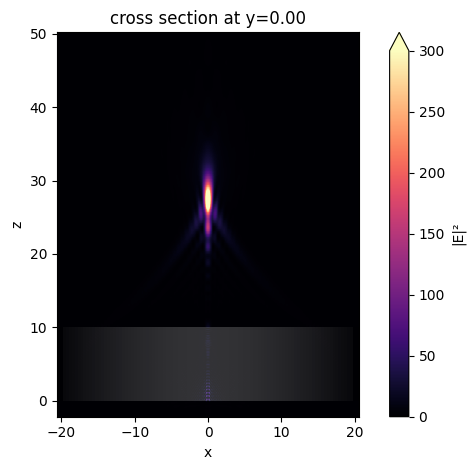

In [21]:
sim_data_lorentz.plot_field("field_xz", "E", "abs^2", vmin=0, vmax=300)
plt.show()


## Custom Anisotropic Medium

With [CustomAnisotropicMedium](../api/_autosummary/tidy3d.CustomAnisotropicMedium.html), one can define a diagonally anisotropic medium in which each component is spatially varying. The usage of [CustomAnisotropicMedium](../api/_autosummary/tidy3d.CustomAnisotropicMedium.html) is similar to [AnisotropicMedium](../api/_autosummary/tidy3d.AnisotropicMedium.html), except that each of its components is a spatially varying medium.

In the following, we illustrate how to define a spatially varying anisotropic medium. We define a medium that is dispersive in the `zz`-component, but non-dispersive in the `xx` and `yy` components. At `freq0`, the medium behaves isotropically, and is identical to the previous custom non-dispersive medium.

### Setup  Simulation with Spatially Varying Lorentz Medium

In [22]:
mat_anisotropic = td.CustomAnisotropicMedium(xx=mat_custom1, yy=mat_custom2, zz=mat_lorentz)


In [23]:
lens_anisotropic = lens.copy(update={"medium":mat_anisotropic})
sim_anisotropic = sim.copy(update={"structures":[lens_anisotropic]})


### Visualize the Simulation and Gradient Index Distribution

Let's visualize the simulation on the same plane as before. To view the permittivity distribution at `freq0`, we set the kwarg `freq=freq0`. The permittivity distribution at `freq0` looks the same as the previous custom non-dispersive medium example.

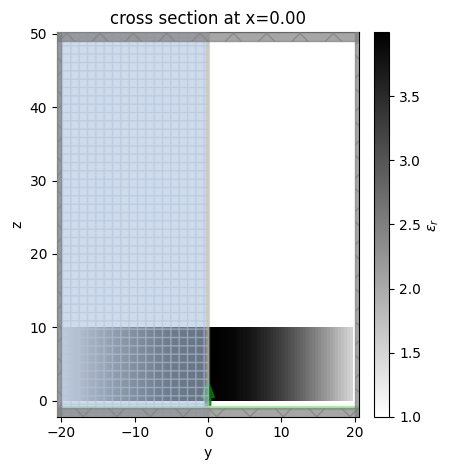

In [24]:
sim_anisotropic.plot_eps(x=0, freq=freq0)
plt.show()


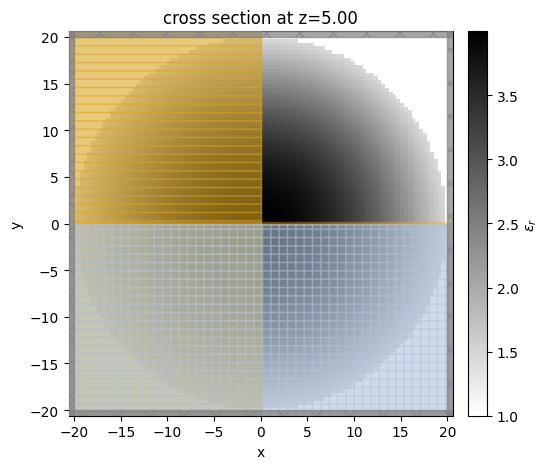

In [25]:
sim_anisotropic.plot_eps(z=t / 2, freq=freq0)
plt.show()


### Submit Simulation Job

Submit the simulation job to the server.

In [26]:
sim_data_anisotropic = web.run(
    sim_anisotropic,
    task_name="gradient_index_lens_anisotropic",
    path="data/simulation_anisotropic.hdf5",
    verbose=True,
)


20:56:43 PST Created task 'gradient_index_lens_anisotropic' with task_id        
             'fdve-65246735-ca8e-42a7-89c2-fff6df36d44c' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=801603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=188485;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\taskId]8;;\]8;id=801603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\=]8;;\]8;id=292694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\fdve]8;;\]8;id=801603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\-65246735-ca8]8;;\
             ]8;id=801603;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\e-42a7-89c2-fff6df36d44c']8;;\.

Output()

20:56:44 PST status = queued

Output()

20:56:49 PST status = preprocess

20:56:52 PST Maximum FlexCredit cost: 0.878. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

20:58:25 PST early shutoff detected at 80%, exiting.

             status = postprocess

Output()

20:58:28 PST status = success

             View simulation result at                                          
             ]8;id=373194;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=493649;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\taskId]8;;\]8;id=373194;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\=]8;;\]8;id=390162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\fdve]8;;\]8;id=373194;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\-65246735-ca8]8;;\
             ]8;id=373194;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65246735-ca8e-42a7-89c2-fff6df36d44c\e-42a7-89c2-fff6df36d44c']8;;\.

Output()

20:58:29 PST loading simulation from data/simulation_anisotropic.hdf5

### Result Visualization

After the simulation is complete, we inspect the focusing capability of the gradient-index lens by plotting the field distributions on the same plane as before. Again, at `freq0`, the result is consistent with the previous simulation.

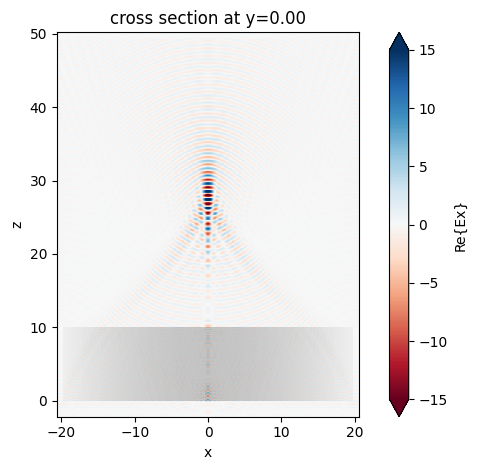

In [27]:
sim_data_anisotropic.plot_field("field_xz", "Ex", vmin=-15, vmax=15)
plt.show()


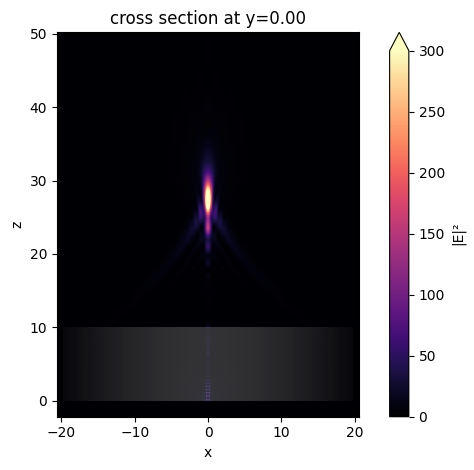

In [28]:
sim_data_anisotropic.plot_field("field_xz", "E", "abs^2", vmin=0, vmax=300)
plt.show()


## Notes:
* By default, subpixel averaging is off on the surface and inside the structure made of custom medium. To apply subpixel on the interface of the structure, including exterior boundary and intersection interfaces with other structures, please set the field `subpixel=True` in custom medium. Here is an example on setting this option in the custom dispersive medium:

In [29]:
mat_lorentz = td.CustomLorentz(
    eps_inf=eps_inf_dataset,
    coeffs=((delep_dataset, f0_dataset, gamma_dataset),),
    subpixel=True,
)